# Executive Hour & Energy price forecasting

This notebook contains a selection of the models that were generated during the course of our work on energy price forecasting. The notebook will initialize each model, train it and then score it according to the validation and test data sets. Finally, all models are compared againts the chosen baseline model.
The target of our project is to predict the day-ahead price (`DA_price`) of electricty in New York city area. The DA price is the price of electricty that is charged at time `t` for delivery of electricty at time `t+24` hours. In contrast to the real-time (`RT`) price, which is for buying and selling electricty on the spot for immediate consumption and is therefore quite volatile, the `DA` price mechanism allows for an element of predictability and stability. 

In our case, we choose a reasonable baseline model: `DA_price` at time `t` is the same as the `DA_price` at time `t-24h`. This generates a baseline model that is surprisingly difficult to beat.

### Group Members:
Irem Altiner, Souparna Purohit, Nicolas Fortier, Rouzbeh Yazdi  
Mentor: Julian Rosen

In [1]:
## imports:
## our own models
import rouz_helpers as rhelp
import rouz_model as rmodel ## Rouz's model(s) --> multi-layered Deep NN and a ResNet
import LSTM as nmodel ## Nic's model(s) --> multi-layered LSTM
import irem_model as imodel ## Irem's model --> ARIMA

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow import keras
import tensorflow as tf

In [3]:
## I am running on an M1 Mac machine and for some reason
## running tensorflow with GPU is a __pain__
tf.config.set_visible_devices([], "GPU")

## Baseline Model, Deep Neural Networks, Residual Networks

In [4]:
validation_scores = {}
test_scores = {}

In [5]:
## Read in the data, remove the first few days
train_df, val_df, test_df = rhelp.read_data_Nic()
train_df['time'] = pd.to_datetime(train_df['time'])
train_df = train_df[train_df.time > datetime(2020,11, 3, 23, 0, 0)]

for df in [train_df, val_df, test_df]:
    _ = df.pop('time')
    
mean = train_df.DA_price.mean()
std = train_df.DA_price.std()

mean_train = train_df.mean(numeric_only=True, axis=0)
std_train = train_df.std(numeric_only=True, axis=0)

train_df = (train_df - mean_train) / std_train
val_df   = (val_df   - mean_train) / std_train
test_df  = (test_df  - mean_train) / std_train

column_indices = {col: train_df.columns.get_loc(col) for col in train_df.columns}

In [6]:
## create windows of time to be fed into the models
SHIFT = 24
BATCH_SIZE = 128
## window no. 1: a narrow window of time, one hour of data, one hour prediction
narrow_window = rhelp.WindowGenerator(
        input_width=1,
        label_width=1,
        shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=["DA_price"],
        batch_size=BATCH_SIZE,
    )
## window no. 2: wide window, passes 24 hours of data for prediction
wide_window = rhelp.WindowGenerator(
        input_width=24,
        label_width=24,
        shift=SHIFT,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=["DA_price"],
        batch_size=BATCH_SIZE,
    )

In [7]:
PATIENCE, MAX_EPOCH = 10, 100

In [8]:
## Baseline model:
baseline_model = rmodel.Baseline(label_index=column_indices["DA_price"])
baseline_model.compile(loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])
validation_scores['Baseline'] = rmodel.get_rmse(baseline_model, wide_window.val, mean, std)
test_scores['Baseline']       = rmodel.get_rmse(baseline_model, wide_window.test, mean, std)

We can now plot the baseline model to take a look. The figures below show the Baseline model against three 24 hour window of data (no specific day or date). (Uncomment the code if you're interested!)

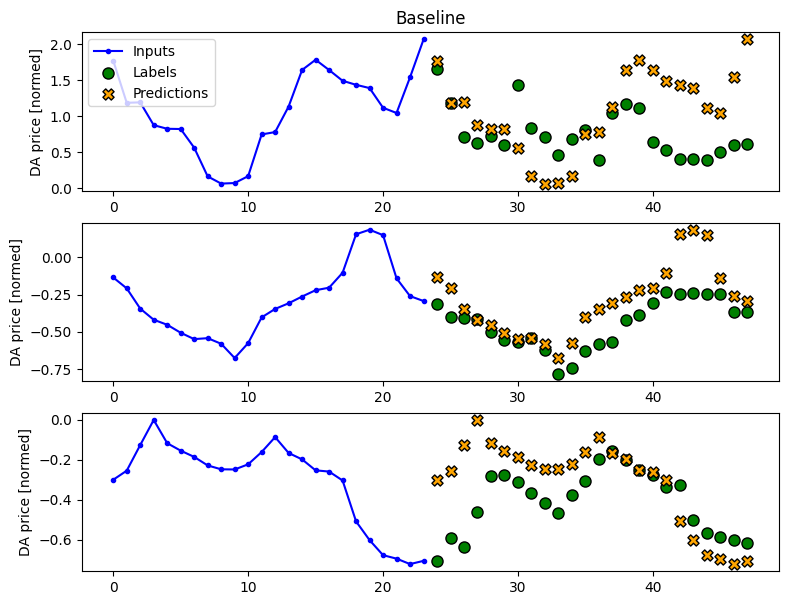

In [9]:
# _ = wide_window.plot(baseline_model, colors=['blue','green','orange'], max_subplots=3, title='Baseline')

In [10]:
## Linear Model:
%timeit
linear_model = rmodel.Linear(units=1)
linear_model_history = rmodel.compile_and_fit(linear_model, 
                                              window=wide_window, 
                                              patience=PATIENCE, 
                                              max_epochs=MAX_EPOCH)
validation_scores['Linear Model'] = rmodel.get_rmse(linear_model, wide_window.val, mean, std)
test_scores['Linear Model']       = rmodel.get_rmse(linear_model, wide_window.test, mean, std)

Now let's see the result of the predictions of the linear model. (Again, uncomment if you're interested!)

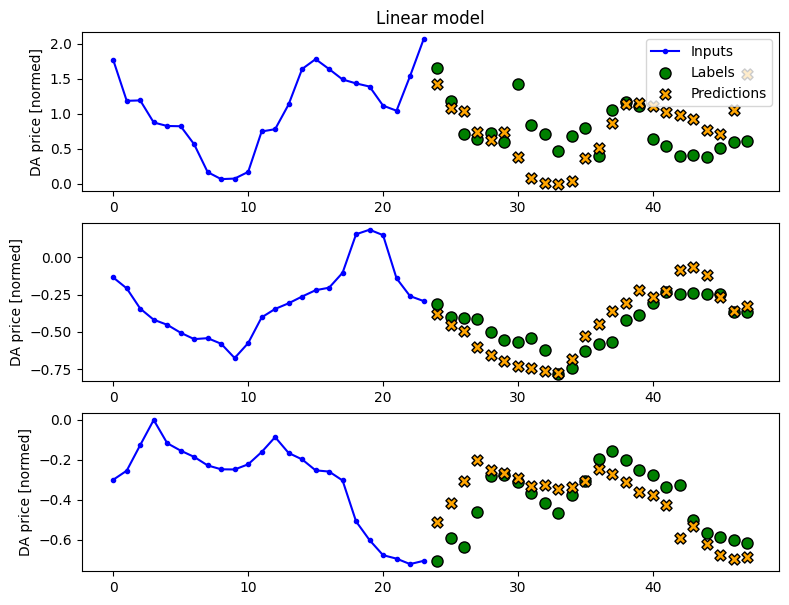

In [11]:
# _ = wide_window.plot(linear_model, colors=['blue','green','orange'], max_subplots=3, title='Linear model')

In [12]:
## Deep Neural Network model:
layers = 3
units = [64, 32, 16]
deep_connected_model = rmodel.DeepDenseModel(num_layers=layers, units=units)
deep_connected_history = rmodel.compile_and_fit(deep_connected_model, wide_window, 
                                                patience=PATIENCE, 
                                                max_epochs=MAX_EPOCH)
validation_scores['Deep Connected NN'] = rmodel.get_rmse(deep_connected_model, wide_window.val, mean, std)
test_scores['Deep Connected NN']       = rmodel.get_rmse(deep_connected_model, wide_window.test, mean, std)

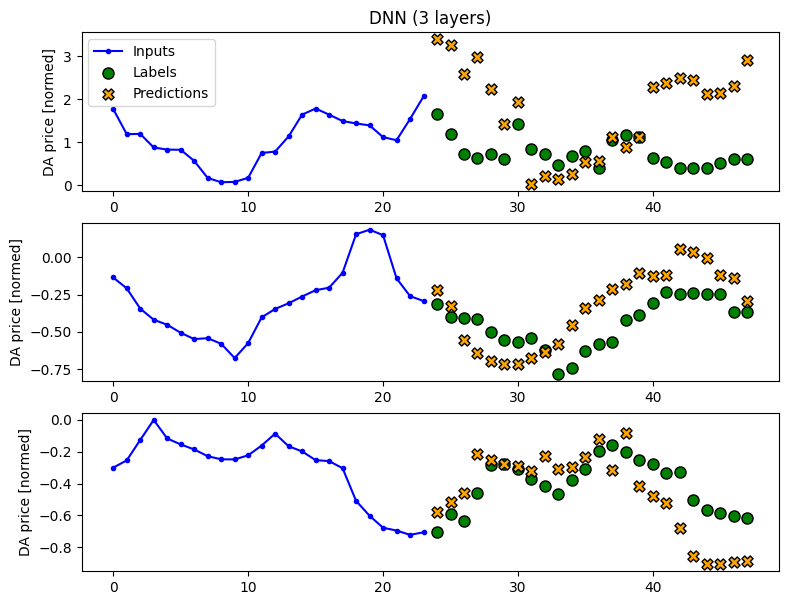

In [13]:
# _ = wide_window.plot(deep_connected_model, colors=['blue','green','orange'], max_subplots=3, title='DNN (3 layers)')

In [14]:
residual_model = rmodel.ResidualNetwork()
residual_model_history = rmodel.compile_and_fit(residual_model, wide_window, 
                                                patience=PATIENCE, 
                                                max_epochs=MAX_EPOCH)
validation_scores['Residual Network'] = rmodel.get_rmse(residual_model, wide_window.val, 
                                                        mean, std, is_residual=True, index=column_indices['DA_price'])
test_scores['Residual Network']       = rmodel.get_rmse(residual_model, wide_window.test, 
                                                        mean, std, is_residual=True, index=column_indices['DA_price'])

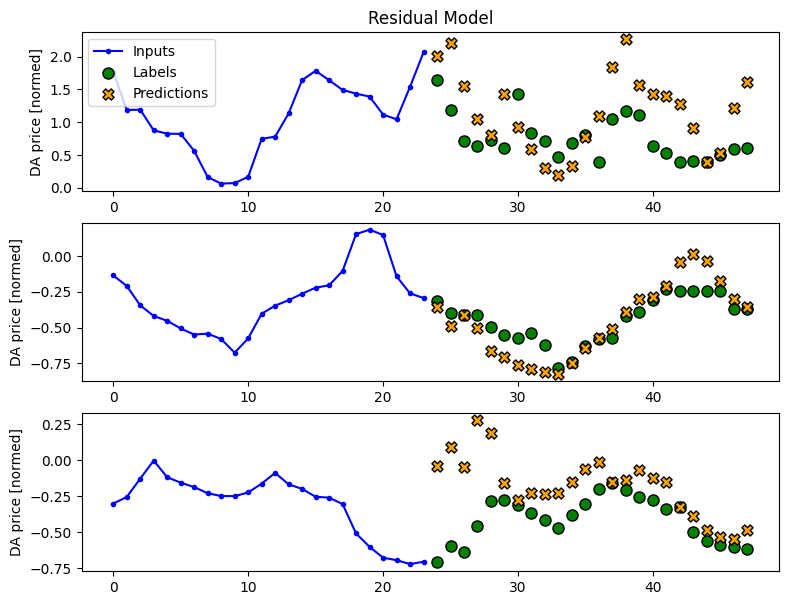

In [15]:
# _ = wide_window.plot(residual_model, colors=['blue','green','orange'], max_subplots=3, title='Residual Model')

## LSTM Model

In [4]:
## the LSTM model by Nic. This is a three layer, LSTM NN
## In calculations, Nic's convention for the name of validation and test
## sets is different (test--> validation, validation -->test)
## that is affected here:
model, LSTM_history, val_rmse, test_rmse = nmodel.main(loc="../final_datasets/")

99/99 [==============================] - 1s 562us/step
Test RMSE: 23.315
177/177 [==============================] - 0s 504us/step
Validation RMSE: 21.526


In [ ]:
validation_scores['LSTM Network'] = val_rmse
test_scores['LSTM Network']       = test_rmse

## ARMIA Model

In [ ]:
train_df, val_df, test_df = rhelp.read_data_Nic()
arima = imodel.ArimaModel(train_df, val_df, test_df)
arima.train_arima()
validation_scores['ARMIA'] = arima.get_validation_rmse()
test_scores['ARMIA']       = arima.get_test_rmse()

## XGBoost

## Plotting the scores

## Conclusions